In [1]:
import os
import h5py
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

# Define the data folder - must include .h5 cas and dat files.
DataFolder = r'/Users/laurenilano/Downloads/THESIS/DATS/'#M1-transient-1100time-step-1-01150.dat.h5'

from cmcrameri import cm

In [2]:
# DOMAIN PARAMETERS - only for plotting purposes.
Ypixels = 1080
XMIN    = -0.25
XMAX    = 0.25
YMIN    = -0.02
YMAX    = 0.08
AspectRatio     = (XMAX-XMIN)/(YMAX-YMIN)
Xpositions      = np.linspace(XMIN,XMAX,int(Ypixels*AspectRatio))
Ypositions      = np.linspace(YMAX,YMIN,Ypixels)
[xgrid,ygrid]   = np.meshgrid(Xpositions,Ypositions)
Clim = [300, 310]

In [3]:
# Read Fluent mesh from case file
casefiles = [f for f in os.listdir(DataFolder) if f.endswith('.cas.h5')]


def get_cells_from_cas(casefile):
    """Obtains cell centroid coordinates from a casefile. 
    Takes vertex indices, maps vertices to faces, and maps faces to cells. 
    Cell centroids are obtained and one zval is ascribed to one cell centroid.
    """
    fname = os.path.join(DataFolder, casefile)

    with h5py.File(fname, 'r') as f:
        VertexList = f['/meshes/1/nodes/coords/1'][:].T  # Shape should be (2, N)
        FaceIdToVertexId = f['/meshes/1/faces/nodes/1/nodes'][:]  # Shape (M,)
        FaceIdToCellId = np.array(f['/meshes/1/faces/c0/1'][:])  # Shape (M/2,)

    # take a cell==face, look at the edges, and then the vertices that make up the edge, then access
    # each coordinate 
    # 1 cell has 4 edges, each with 2 vertices, so overall 1 cell has 8 rows; 
    
    # Reshape VertexList based on FaceIdToVertexId (adjusting to 0-based index)
    vertex_indices = FaceIdToVertexId - 1  # Convert to 0-based index
    vertex_coords_x = VertexList[0, vertex_indices]
    vertex_coords_y = VertexList[1, vertex_indices]

    # Reshape into pairs of vertices for each face
    vertex_coords_x = vertex_coords_x.reshape((2, -1), order='F')
    vertex_coords_y = vertex_coords_y.reshape((2, -1), order='F')

    # Compute face centers
    # the face center is the average of the x and y vertex coords of the current cell, acc to cell ID.
    face_centers_x = np.mean(vertex_coords_x, axis=0)
    face_centers_y = np.mean(vertex_coords_y, axis=0)

    # Initialize cell centroids
    num_cells = np.max(FaceIdToCellId)
    CellX = np.zeros(num_cells)
    CellY = np.zeros(num_cells)
    counts = np.zeros(num_cells, dtype=int)

    # Aggregate face centers to compute cell centroids
    for i in range(len(FaceIdToCellId)):
        cell_id = FaceIdToCellId[i] - 1  # Adjust to 0-based index
        CellX[cell_id] += face_centers_x[i]
        CellY[cell_id] += face_centers_y[i]
        counts[cell_id] += 1

    # Compute centroids by dividing by the counts
    CellX /= counts
    CellY /= counts

    return CellX, CellY

In [4]:
casefile = casefiles[0]
CellX, CellY = get_cells_from_cas(casefile)

def get_xyz(CellX, CellY, datafile):
    """Maps cell centroid coordinates to zvalues from a datafile. 
    """
    fname = os.path.join(DataFolder, datafile)
    
    with h5py.File(fname, 'r') as f:
        T = f['/results/1/phase-1/cells/SV_T/1'][:]
        return T
    
    
def get_interpolated_contour(CellX, CellY, datafile):
    """Map cell centroid coordinates to zvalues from a datafile.
    Interpolates the cell centers + associated z value to a uniform grid
    for plotting purposes.
    """
    fname = os.path.join(DataFolder, datafile)
    
    Z = get_xyz(CellX, CellY, fname)
    
    # DOMAIN PARAMETERS - only for plotting purposes.
    Ypixels = 1080
    XMIN    = -0.25
    XMAX    = 0.25
    YMIN    = -0.02
    YMAX    = 0.08
    AspectRatio     = (XMAX-XMIN)/(YMAX-YMIN)
    Xpositions      = np.linspace(XMIN,XMAX,int(Ypixels*AspectRatio))
    Ypositions      = np.linspace(YMAX,YMIN,Ypixels)
    [xgrid,ygrid]   = np.meshgrid(Xpositions,Ypositions)
    Clim = [300, 310]

    if len(CellX) == len(CellY) == len(Z):
        from scipy.interpolate import griddata
        SI = griddata((CellX, CellY), Z, (xgrid, ygrid), method='linear', fill_value=np.nan)
        return SI
    else:
        raise ValueError("Lengths of CellX, CellY, and T do not match!")

def query_point(CellX, CellY, z, query_x, query_y):
    """Given a set of cell coords CellX, CellY, and a requested coordinate index,
    obtain the corresponding z value from the entire z array. 
    
    """
    tolerance = 1e-4
    rtol=1e-7
    new_index = np.where(np.isclose(CellX, query_x, atol=tolerance, rtol=rtol) & np.isclose(CellY, query_y, atol=tolerance, rtol=rtol))
    
    return new_index, z[new_index]

In [5]:
# Read temperature data
datafiles = [f for f in os.listdir(DataFolder) if f.endswith('dat.h5')]

temp = get_xyz(CellX, CellY, datafiles[0])

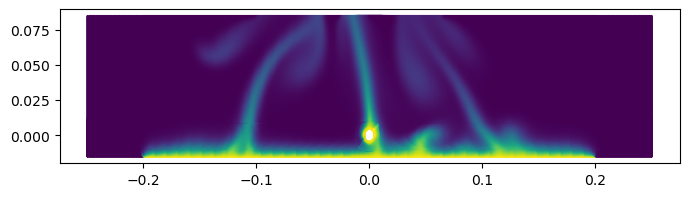

In [6]:
# Proof that they are mapped properly
fig, ax = plt.subplots(figsize=(8,2))
ax.scatter(CellX, CellY, c=temp, cmap='viridis', s=1)

If we wanna query specific points in the raw array, we cannot use indices as they arent necessarily in order. but the values of x and y coords are so close in magnitude we cannot use np.where and `==` either. 

Update - found we can use isclose given a 1e-4 threshold.

In [7]:
import pandas as pd

#data_out = np.column_stack((CellX, CellY, temp))
#temp_df = pd.DataFrame(list(data_out), columns=["CellX", "CellY", "Temp"])
#temp_df.to_csv('./test.csv')

In [8]:
query_x = 0
query_y = 0.025
_, query_temp = query_point(CellX, CellY, z=temp, query_x=query_x, query_y=query_y)
query_temp

array([303.67818153])

Now we have the functionality to do this through time - gonna write this so we can do this in parallel maybe..?

In [9]:
def get_point_time_series(CellX, CellY, datafile, x, y, datatype="temp"):
    """Given a casefile for one Tr and datafile for all h5 contours, obtain
    the zval time series for a query point over that entire data collection period.
    """
    # Get z array
    z = get_xyz(CellX, CellY, datafile)
    _, query_temp = query_point(CellX, CellY, z, query_x=x, query_y=y)
    corresponding_timestep = datafile.split(".")[0].split("-")[-1]
    return corresponding_timestep, query_temp

In [10]:
from joblib import Parallel, delayed

In [11]:
%env PYTHONWARNINGS=ignore::UserWarning

x = 0
y = 0.025

# Use LokyBackend to protect the netCDF routine
temp_series = Parallel(n_jobs=-1, backend='loky', verbose=1) \
(delayed(get_point_time_series) \
 (CellX, CellY, datafile,
  x, y
 ) for datafile in datafiles)

env: PYTHONWARNINGS=ignore::UserWarning


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.8s finished


Goal: get h5 outputs on a hard drive

# Sample interpolated contour for report

In [13]:
SI = get_interpolated_contour(CellX, CellY, datafiles[0])

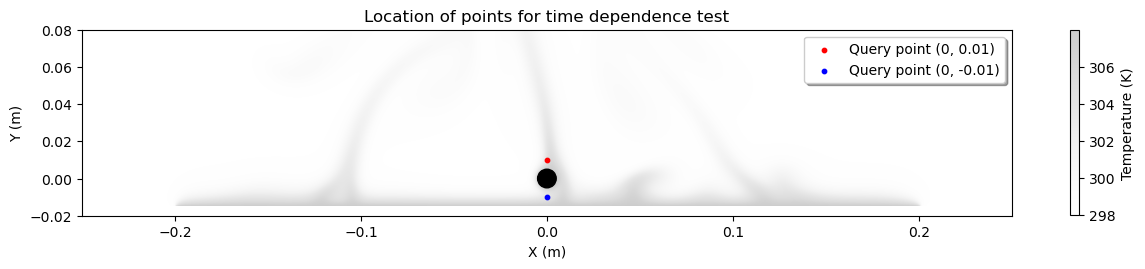

In [14]:
fig, ax = plt.subplots(figsize=(15,12))

#Clim = [np.min(T), np.max(T)]

# Create initial image
#ax.scatter(CellX, CellY, c='blue', label='Cell centroids')
p_ = ax.imshow(SI, extent=[XMIN, XMAX, YMIN, YMAX], cmap='Greys', alpha=0.2)

ax.set_ylim([YMIN, YMAX])
circle = plt.Circle((0, 0), 0.005, color='black', fill=True)
ax.add_patch(circle)

ax.scatter([0], [0.01], s=10, c='red', label="Query point (0, 0.01)")
ax.scatter([0], [-0.01], s=10, c='b', label="Query point (0, -0.01)")
plt.colorbar(p_, ax=ax, label='Temperature (K)', shrink=0.2, )
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Location of points for time dependence test')
plt.legend(frameon=True, fancybox=True, shadow=True)

#plt.savefig('./points_For_mesh_time_Dep.pdf', dpi=300, bbox_inches='tight')

#plt.close()


# Autocorrelation

In [15]:
import pandas as pd

# Temperature series 
series_path = "/Users/laurenilano/Downloads/THESIS/PointFiles/Tr_11_22-08-2024/"
series_fname = series_path+"temp-top.out"

point_data = pd.read_table(series_fname, delimiter=' ', skiprows=2)
point_data = point_data.rename(columns={'("Time' : 'Iteration', 'Step"' : "Timestep", 'flow-time' : "Temp"})
temperatures = point_data['Temp'].to_numpy()
timestep = point_data['Timestep'].to_numpy()

In [16]:
# Compute the autocorrelation
autocorr = np.correlate(temperatures - np.mean(temperatures), temperatures - np.mean(temperatures), mode='full')

# Normalize the autocorrelation

# Take only the 2nd half to get rid of negative lags
autocorr = autocorr[autocorr.size // 2:]
autocorr /= autocorr[0]

In [17]:
def autocovariance(x, lag):
    n = len(x)
    mean = np.mean(x)
    return np.sum((x[:n-lag] - mean) * (x[lag:] - mean)) / n

acovar = []

tau = np.arange(0, 40000,1)
for lag in tau:
    acovariance = autocovariance(temperatures, lag)
    acovar.append(acovariance)
    
autocorr2 = acovar/np.std(temperatures)**2

Text(0, 0.5, 'Autocorrelation')

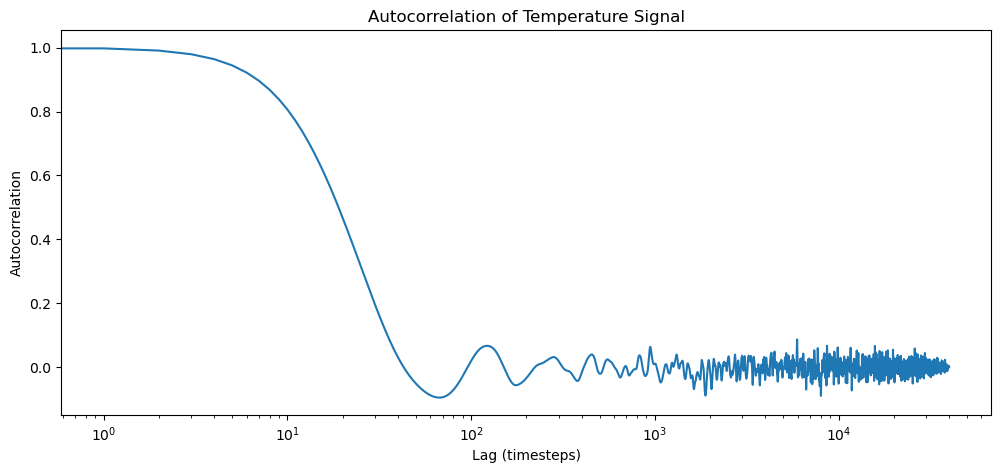

In [18]:
# Plot the autocorrelation
fig, ax = plt.subplots(figsize=(12,5))
#ax.plot(autocorr2)
ax.semilogx(autocorr2)
ax.set_title('Autocorrelation of Temperature Signal')
ax.set_xlabel('Lag (timesteps)')
ax.set_ylabel('Autocorrelation')

Where curve intersects 0 autocorrelation is the number of timesteps to the integral time scale.


## GOAL: query different points across the (CellX, CellY, T) domain and pick areas where there will be more movement of plumes - try to capture the smallest integral timescale.

This will relate directly to the deltaT for frequency of saving h5 files. 

query x=d/2 

## REMEMBER: since we are working with cell centroids, artificially add a point at the wall face, y0=0, T0=308.

heat is joules. 
flux = heat energy thru an aerea per second 

The operation below is NOT correct as this is done on the even interpolated grid. Do this on the 

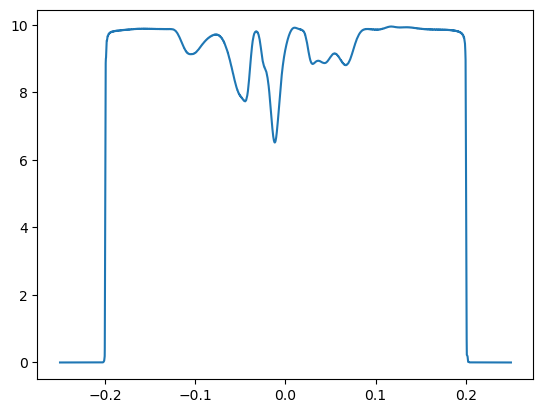

In [19]:
heat_flux_at_x = []
for i, x in enumerate(Xpositions):
    temp_along_y = SI[:,i]
    
    dT_dy = np.nansum(np.gradient(temp_along_y, axis=0))
    
    L = 0.2
    
    #if np.abs(x) <= L:
    heat_flux_at_x.append(dT_dy)
    
plt.plot(Xpositions,heat_flux_at_x)